In [162]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.direct_model import DirectModel
from sasdata.dataloader.loader import Loader
from sasmodels import weights
from sasmodels.data import empty_data1D

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps import parameter


## calculate expected scattering from a distribution

In [129]:
sld_silica = 8.575
sld_etoh = 9.611

q_min = -4
q_max = 0
n_q = 501

# r in nm
r_min = 20
r_max = 500
n_r = 501

delta_sld = np.abs(sld_silica - sld_etoh)





In [130]:
## sphere scattering


def I_sphere(q, r, delta_sld):
    V_sphere = volume_sphere(r)

    Pq = ((3*(np.sin(q*r) - q*r*np.cos(q*r)))/((q*r)**3))**2
    
    return (delta_sld**2)*(V_sphere**2)*Pq
    

In [131]:
## scattering intentsity volume correction

In [132]:
## volume of a sphere
def volume_sphere(r):
    return (4/3)*np.pi*r**3

In [133]:
## calculate scattering for a grid of radii

In [134]:
## define a distribution 

In [135]:
## weighted average of each scatterer from distribution

In [136]:
q = np.logspace(q_min, q_max, n_q)

In [137]:
q

array([1.00000000e-04, 1.01859139e-04, 1.03752842e-04, 1.05681751e-04,
       1.07646521e-04, 1.09647820e-04, 1.11686325e-04, 1.13762729e-04,
       1.15877736e-04, 1.18032064e-04, 1.20226443e-04, 1.22461620e-04,
       1.24738351e-04, 1.27057411e-04, 1.29419584e-04, 1.31825674e-04,
       1.34276496e-04, 1.36772883e-04, 1.39315680e-04, 1.41905752e-04,
       1.44543977e-04, 1.47231250e-04, 1.49968484e-04, 1.52756606e-04,
       1.55596563e-04, 1.58489319e-04, 1.61435856e-04, 1.64437172e-04,
       1.67494288e-04, 1.70608239e-04, 1.73780083e-04, 1.77010896e-04,
       1.80301774e-04, 1.83653834e-04, 1.87068214e-04, 1.90546072e-04,
       1.94088588e-04, 1.97696964e-04, 2.01372425e-04, 2.05116218e-04,
       2.08929613e-04, 2.12813905e-04, 2.16770410e-04, 2.20800473e-04,
       2.24905461e-04, 2.29086765e-04, 2.33345806e-04, 2.37684029e-04,
       2.42102905e-04, 2.46603934e-04, 2.51188643e-04, 2.55858589e-04,
       2.60615355e-04, 2.65460556e-04, 2.70395836e-04, 2.75422870e-04,
      

In [138]:
I = I_sphere(q, 50, delta_sld)

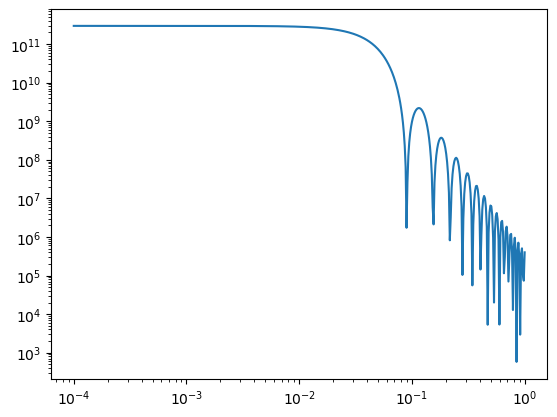

In [139]:
plt.loglog(q, I)

In [140]:
## calculate scattering over a range of radii

In [141]:
r_range = np.linspace(r_min, r_max, n_r)

In [142]:
intensities = np.zeros((len(r_range), len(q)))
for i, r in enumerate(r_range):
    intensities[i,:] = I_sphere(q, r, delta_sld)

In [143]:
intensities

array([[1.20524782e+09, 1.20524779e+09, 1.20524775e+09, ...,
        6.20477372e+04, 3.28671106e+04, 8.90551440e+03],
       [1.59677608e+09, 1.59677603e+09, 1.59677597e+09, ...,
        2.44794762e+03, 3.35000112e+03, 2.29159490e+04],
       [2.08900563e+09, 2.08900556e+09, 2.08900548e+09, ...,
        4.43288728e+04, 7.29306345e+04, 8.15529185e+04],
       ...,
       [2.87392784e+17, 2.87387432e+17, 2.87381880e+17, ...,
        3.32968821e+07, 9.40831524e+06, 8.13794211e+05],
       [2.90731810e+17, 2.90726375e+17, 2.90720737e+17, ...,
        4.38462755e+07, 4.43554233e+07, 3.35102953e+07],
       [2.94103099e+17, 2.94097580e+17, 2.94091854e+17, ...,
        4.79671812e+06, 2.27077361e+07, 3.30305487e+07]])

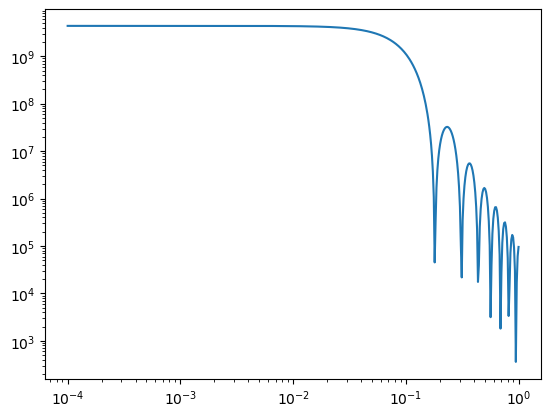

In [144]:
plt.loglog(q, intensities[5, :])

In [194]:
## define a distribution

mean_r = 40 # nm, 120 nm d

# polydispersity definition from https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/pd/polydispersity.html
pdi = 0.1
var = pdi*mean_r
std = np.sqrt(var)

dist = scipy.stats.distributions.norm(loc = mean_r, scale = std)

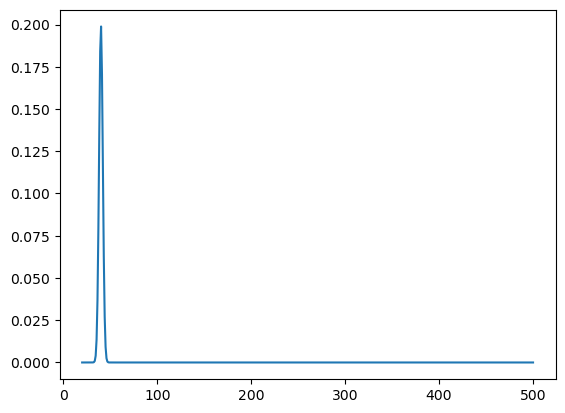

In [195]:
plt.plot(r_range, dist.pdf(r_range))

In [196]:
## calculate average intensity over r, weighted by distribution

weights = dist.pdf(r_range)

In [197]:
weighted_I = intensities * weights.reshape(-1,1)

In [198]:
average_I = np.average(weighted_I, axis=0)

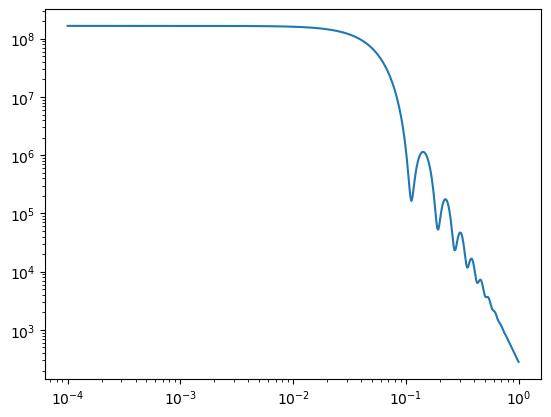

In [199]:
plt.loglog(q, average_I)

## try with sasmodels sphere

In [154]:
kernel = load_model('sphere')

In [163]:
data = empty_data1D(q)

In [180]:
pars = dict(scale = 1, background = 0.001, sld = 1, radius = 50)
model = DirectModel(data, kernel)
#model.radius.range(10, 5000)
#model.scale.range(0, 5)

#model.radius_pd.range(0,0.2)
#model.radius_pd_type = 'lognormal'
model.model.info.parameters.kernel_parameters

[P<sld>, P<sld_solvent>, P<radius>]

In [181]:
kernel.info.parameters.kernel_parameters

[P<sld>, P<sld_solvent>, P<radius>]

In [210]:
I = model(radius = 40, radius_pd = 0.1, radius_pd_type = 'gaussian', radius_pd_n = 35, radius_pd_nsigma = 3)

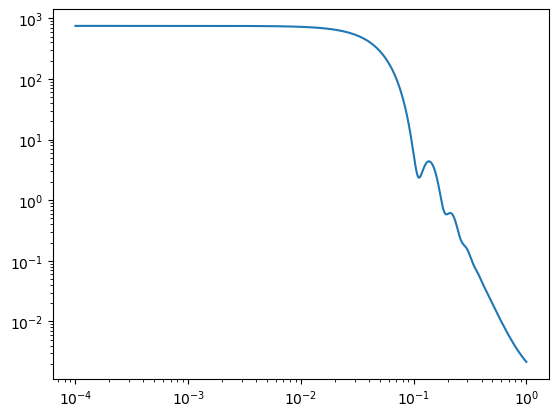

In [211]:
plt.loglog(q, I)

In [159]:
Model

sasmodels.bumps_model.Model